In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from scipy import stats
import scipy.io as sio

Load & Reorder:

In [2]:
# Load
SAT_4 = sio.loadmat('flatten_SAT_4.mat')
train_x = SAT_4['train_x']
train_y = SAT_4['train_y']

Model parameters: 

In [3]:
width = 28
height = 28
band = 4

L1_out = 1024
L2_out = 512
L3_out = 256
L4_out = 128
class_output = 4 # number of possible classifications for the problem

batch_size = 64
learning_rate = 9e-6

Calculate Normalization Parameters:

In [4]:
# Normalize Parameters
mu = train_x.mean(axis=0, keepdims=True)
sigma = 0
for img in train_x:
    sigma += (img-mu)**2
sigma /= train_x.shape[0]

$a_i$ is the raw number (int)

$\mu = \frac 1 n \sum_{i=1}^n \frac {a_i} {\text{Max}} = \frac 1 {\text{Max}}(\frac 1 n \sum_{i=1}^n a_i)$

$\sigma = \sqrt{\frac 1 n \sum_{i=1}^n (\frac{a_i}{\text{Max}}-\mu)^2 } = \frac 1 {\text{Max}} \sqrt{\frac 1 n \sum_{i=1}^n(a_i-\mu*\text{Max})^2 } $

$\displaystyle \frac {\frac A {\text{Max}} - mu} {\sigma} = \frac {A-\mu *\text{Max}}{\sigma *\text{Max}}$

Place holders for inputs and outputs: 

In [5]:
x  = tf.placeholder(tf.float32, shape=[None, width*height*band])
y_ = tf.placeholder(tf.float32, shape=[None, class_output])

Fully Connected Layer: 

In [6]:
# Layer 1
W_fc1 = tf.Variable(tf.truncated_normal([width*height*band, L1_out], stddev=0.1))
b_fc1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))

fc1=tf.matmul(x, W_fc1) + b_fc1 # applying weights and biases
h_fc1 = tf.nn.relu(fc1) # ReLU activation

# Layer 2
W_fc2 = tf.Variable(tf.truncated_normal([L1_out, L2_out], stddev=0.1))
b_fc2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))

fc2=tf.matmul(h_fc1, W_fc2) + b_fc2# applying weights and biases
h_fc2 = tf.nn.relu(fc2) # ReLU activation

# Layer 3
W_fc3 = tf.Variable(tf.truncated_normal([L2_out, L3_out], stddev=0.1))
b_fc3 = tf.Variable(tf.truncated_normal([L3_out], stddev=0.1))

fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
h_fc3 = tf.nn.relu(fc3) # ReLU activation

# Layer 4
W_fc4 = tf.Variable(tf.truncated_normal([L3_out, L4_out], stddev=0.1))
b_fc4 = tf.Variable(tf.truncated_normal([L4_out], stddev=0.1))

fc4=tf.matmul(h_fc3, W_fc4) + b_fc4
h_fc4 = tf.nn.relu(fc4) # ReLU activation

Output Layer (Softmax):

In [7]:
W_fc_out = tf.Variable(tf.truncated_normal([L4_out, class_output], stddev=0.1))
b_fc_out = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

fc_out=tf.matmul(h_fc4, W_fc_out) + b_fc_out

y_CNN= tf.nn.softmax(fc_out)

Cost function & optimizer:

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * (y_CNN), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [9]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Train & monitor:

6250
start
step 0     : train_acc = 0.28125  , cross entropy = -0.260183 
step 1000  : train_acc = 0.75     , cross entropy = -0.719297 
step 2000  : train_acc = 0.828125 , cross entropy = -0.804142 
step 3000  : train_acc = 0.890625 , cross entropy = -0.876897 
step 4000  : train_acc = 0.90625  , cross entropy = -0.887656 
step 5000  : train_acc = 0.921875 , cross entropy = -0.908518 
step 6000  : train_acc = 0.875    , cross entropy = -0.861315 
step 7000  : train_acc = 0.890625 , cross entropy = -0.862979 
step 8000  : train_acc = 0.890625 , cross entropy = -0.859857 
step 9000  : train_acc = 0.90625  , cross entropy = -0.899601 
step 10000 : train_acc = 1        , cross entropy = -0.981286 
step 11000 : train_acc = 0.90625  , cross entropy = -0.896329 
step 12000 : train_acc = 0.890625 , cross entropy = -0.893463 
step 13000 : train_acc = 0.953125 , cross entropy = -0.945097 
step 14000 : train_acc = 0.921875 , cross entropy = -0.924239 
step 15000 : train_acc = 0.859375 , cross en

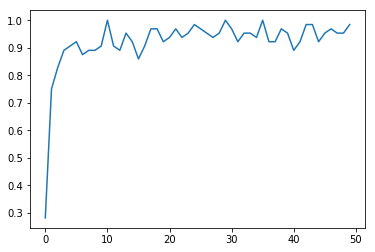

In [10]:
batch_num = int(len(train_x)/batch_size)
print(batch_num)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print("start")
learning_curve = []
for i in range(50000):
    start = (i%batch_num) * batch_size
    end = start + batch_size
    batch = [((train_x[start:end]-mu)/sigma), train_y[start:end]]
    
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})

        learning_curve.append(train_accuracy)
        print("step %-6d: train_acc = %-9g, cross entropy = %-10f"
              %(i, train_accuracy, cross_entropy.eval(feed_dict={x:batch[0], y_: batch[1]})))
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
print("finish")

plt.plot(learning_curve)
plt.show()

Evaluate:

In [11]:
train_acc = []
for i in range(40000):
    start = (i%40000)*10
    end = start + 10
    batch = [((train_x[start:end]-mu)/sigma), train_y[start:end]]

    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
    train_acc.append(train_accuracy)
print(sum(train_acc)/len(train_acc))

0.956914994098


In [12]:
test_x = SAT_4['test_x']
test_y = SAT_4['test_y']

test_acc = []
for i in range(10000):
    start = i*10
    end = start+10
    test_acc.append(accuracy.eval(
        feed_dict={x:((test_x[start:end]-mu)/sigma), y_:test_y[start:end]}))
    
print(sum(test_acc)/len(test_acc))

0.951519993699


In [13]:
sess.close() #finish the session